# Assignment 2 - Credit card Fraud Detection
Dataset from: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve

In [2]:
df = pd.read_csv("../data/creditcard.csv")
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### Data pre-processing

In [3]:
print(df.shape)
df.describe()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# No null values
df.isnull().sum().max()

0

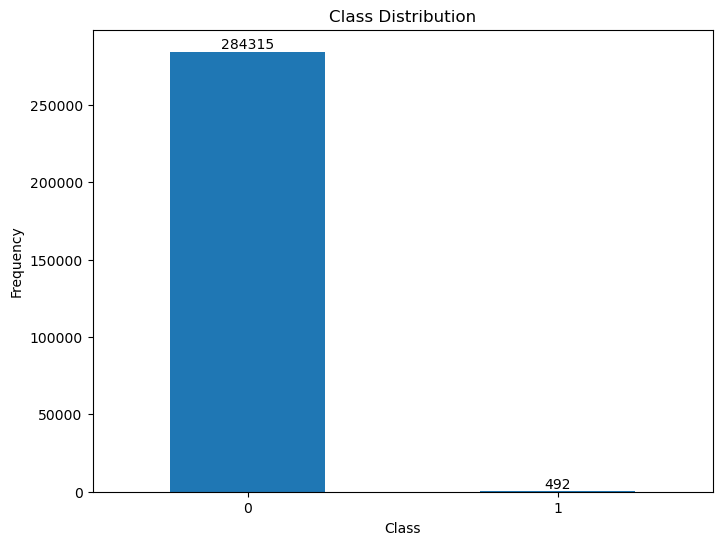

In [5]:
# counting occurences in each class
class_counts = df['Class'].value_counts()

# Plot the bar plot
plt.figure(figsize=(8, 6))
ax = class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  

# Add labels on the bars
for i in range(len(class_counts)):
    plt.text(i, class_counts[i], str(class_counts[i]), ha='center', va='bottom')

plt.show()

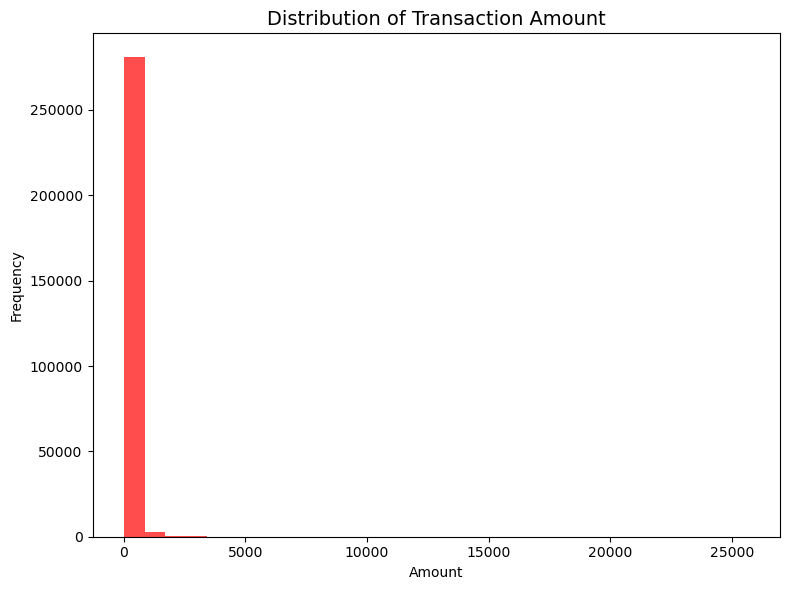

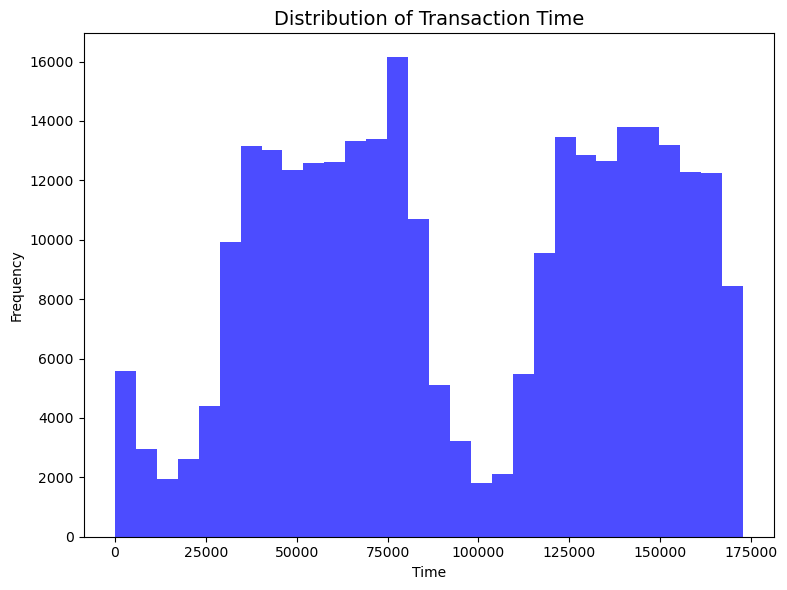

In [6]:
# This code cell is to plot the distribution of the "Amount" and "Time" columns

# Extract values
amount_val = df['Amount'].values

# Create a chart for Amount
plt.figure(figsize=(8, 6))

# Plot distribution of Amount
plt.hist(amount_val, bins=30, color='r', alpha=0.7)
plt.title('Distribution of Transaction Amount', fontsize=14)
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Extract values
time_val = df['Time'].values

# Create a figure for Time
plt.figure(figsize=(8, 6))

# Plot distribution of Time
plt.hist(time_val, bins=30, color='b', alpha=0.7)
plt.title('Distribution of Transaction Time', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Scale Time and Amount columns

In [8]:
from sklearn.preprocessing import RobustScaler

# Most columns are scaled due to the PCA transformation. We need to scale Amount and Time columns too.

# RobustScaler is less prone to outliers as it uses the median and interquartile 
# range instead of the mean and standard deviation.

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled and put placed into first 2 columns
df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [9]:
print(df['scaled_time'].mean())
print(df['scaled_amount'].mean())
print(df['scaled_amount'].max())
print(df['scaled_amount'].min())

0.11891422097393842
0.9271238629348331
358.6831551736184
-0.30741284147278697


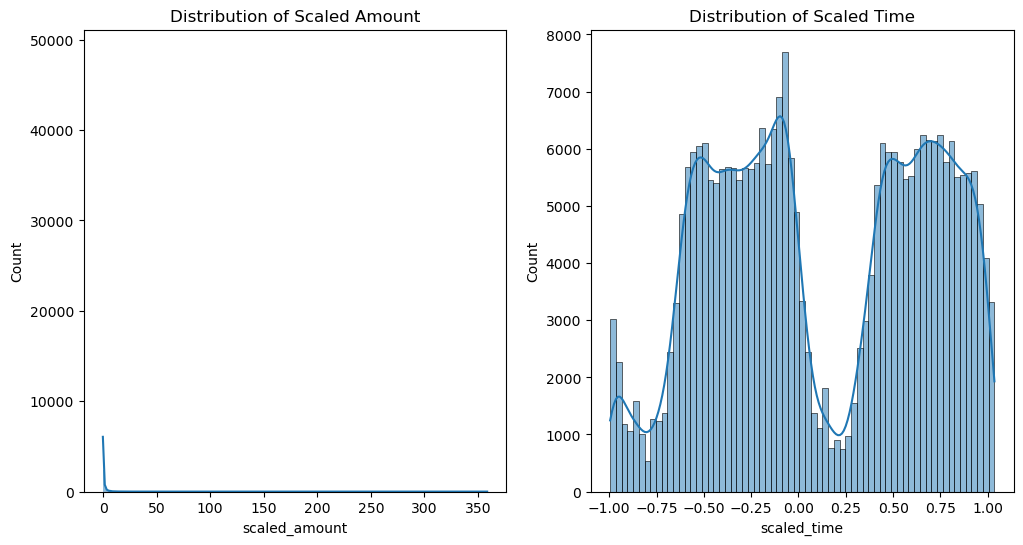

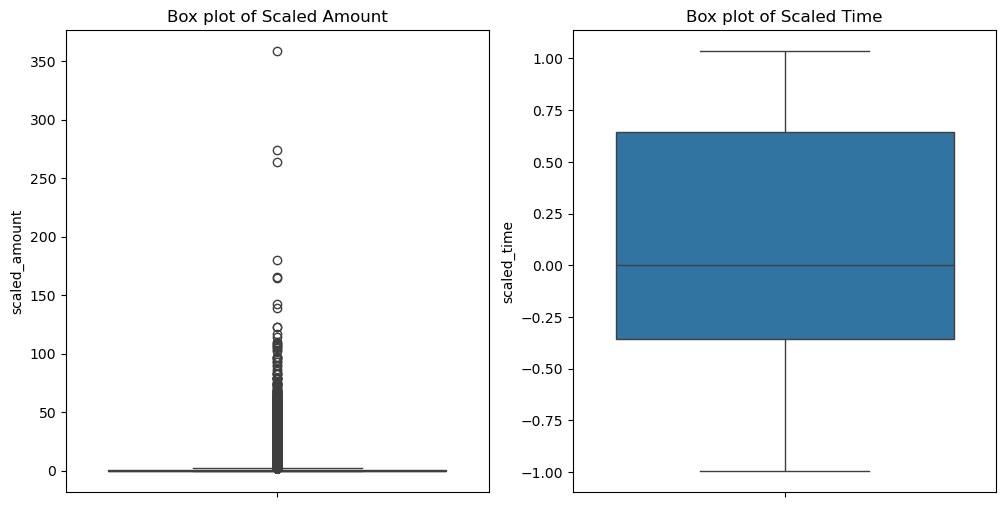

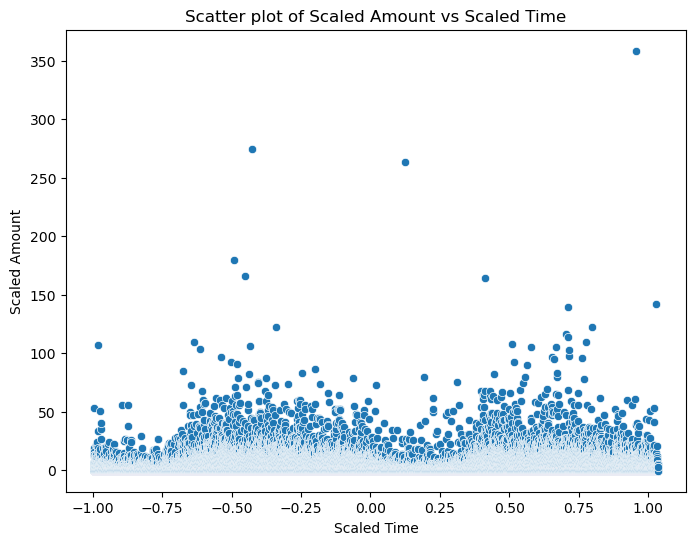

In [10]:
# Charts for visualisation

plt.figure(figsize=(12, 6))

# Histogram for scaled_amount
plt.subplot(1, 2, 1)
sns.histplot(df['scaled_amount'], kde=True)
plt.title('Distribution of Scaled Amount')

# Histogram for scaled_time
plt.subplot(1, 2, 2)
sns.histplot(df['scaled_time'], kde=True)
plt.title('Distribution of Scaled Time')

plt.show()

# Box plots to see the spread and outliers
plt.figure(figsize=(12, 6))

# Box plot for scaled_amount
plt.subplot(1, 2, 1)
sns.boxplot(y=df['scaled_amount'])
plt.title('Box plot of Scaled Amount')

# Box plot for scaled_time
plt.subplot(1, 2, 2)
sns.boxplot(y=df['scaled_time'])
plt.title('Box plot of Scaled Time')

plt.show()

# Scatter plot to see the relationship between scaled_amount and scaled_time
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['scaled_time'], y=df['scaled_amount'])
plt.title('Scatter plot of Scaled Amount vs Scaled Time')
plt.xlabel('Scaled Time')
plt.ylabel('Scaled Amount')
plt.show()


### Models - Steps to take

- Check correlations between features and label (do after you've resampled as highly imbalanced labels will influence correlation coefficients)
- Remove extreme outliers from features (anomaly detection?) if have time.

-------


- Apply ML model and calculate F1 score
- Random under sampling || Oversmapling || Combined  
- Other steps?


#### Splitting the test set before any under or oversampling technique is applied

In [11]:
print(df['Class'].value_counts())
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

0    284315
1       492
Name: Class, dtype: int64
No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [12]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test, return_counts=True)

print('Label Distributions in training and test set: \n')
print(train_counts_label/ len(y_train))
print(test_counts_label/ len(y_test))
print('-' * 100)
print(pd.DataFrame(y_train).value_counts())
print(pd.DataFrame(y_test).value_counts())

Label Distributions in training and test set: 

[0.99827075 0.00172925]
[0.99827955 0.00172045]
----------------------------------------------------------------------------------------------------
Class
0        227451
1           394
dtype: int64
Class
0        56864
1           98
dtype: int64


#### Logistic Regression

In [135]:
print(y_train.shape)
print(y_test.shape)

print(y_train.value_counts())
print(y_test.value_counts())

(227845,)
(56962,)
0    227451
1       394
Name: Class, dtype: int64
0    56864
1       98
Name: Class, dtype: int64


In [11]:
# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Measure code cell time
start_time = time.time()

# Initialise the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Perform 5-fold cross-validation on the training set
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = cross_val_score(log_reg, X_train, y_train, cv=kf, scoring='f1')

# Print cross-validation F1 scores and mean score
print("Cross-Validation F1 Scores:", f1_scores)
print("Mean F1 Score:", np.mean(f1_scores))


# Train the model on the entire training set
log_reg.fit(X_train, y_train)
# Predict on the test set
y_pred = log_reg.predict(X_test)
# Evaluat model using the F1 score on the test set
f1_test = f1_score(y_test, y_pred)

# Print the F1 score and classification report
print("Test Set Performance:")
print("F1 Score:", f1_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Print the confusion matrix 
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# record time and print
end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken to run code cell: {time_taken} seconds")

Cross-Validation F1 Scores: [0.73282443 0.73282443 0.75862069 0.71532847 0.73529412]
Mean F1 Score: 0.7349784258834695
Test Set Performance:
F1 Score: 0.7314285714285713
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.83      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56851    13]
 [   34    64]]
Time taken to run code cell: 7.9575018882751465 seconds


In [12]:
print(y_train.shape)
print(y_test.shape)

print(y_train.value_counts())
print(y_test.value_counts())

(227845,)
(56962,)
0    227451
1       394
Name: Class, dtype: int64
0    56864
1       98
Name: Class, dtype: int64


#### Logistic regression with custom Decision Threshold

Mean F1 Score across folds: 0.7958625627818094
Mean Optimal Threshold across folds: 0.13090442657922657
F1 Score on Test Set with Custom Threshold: 0.7462686567164178
Classification Report on Test Set with Custom Threshold:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.73      0.77      0.75        98

    accuracy                           1.00     56962
   macro avg       0.86      0.88      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix on Test Set with Custom Threshold:
[[56836    28]
 [   23    75]]


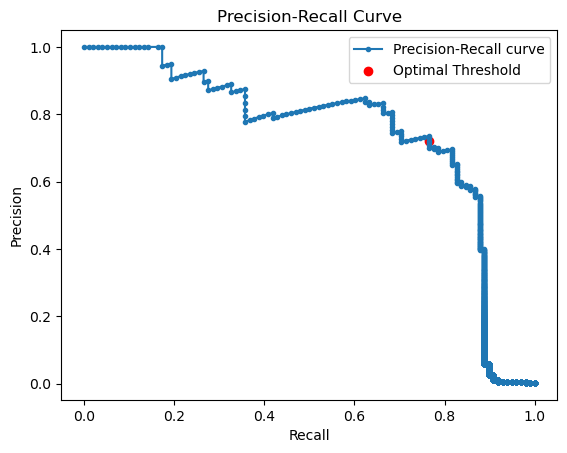

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialisimng  model
log_reg = LogisticRegression(max_iter=1000)

# Initialise Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store F1 scores and thresholds
f1_scores = []
optimal_thresholds = []

# Cross-validationn for loop
for train_idx, val_idx in cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the model
    log_reg.fit(X_train_fold, y_train_fold)

    # Predict probabilities on the validation set
    y_val_prob = log_reg.predict_proba(X_val_fold)[:, 1]

    # Find the precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_val_fold, y_val_prob)

    # Compute F1 scores for each threshold
    f1_scores_fold = 2 * (precision * recall) / (precision + recall)
    
    # Find the threshold that maximizes the F1 score
    optimal_idx = np.argmax(f1_scores_fold)
    optimal_threshold = thresholds[optimal_idx]

    # Store the optimal threshold
    optimal_thresholds.append(optimal_threshold)

    # Predict classes using the custom threshold
    y_val_pred_custom_threshold = (y_val_prob >= optimal_threshold).astype(int)

    # Evaluate the model using the custom threshold
    f1 = f1_score(y_val_fold, y_val_pred_custom_threshold)
    f1_scores.append(f1)

# Print the average F1 score and optimal threshold across folds
mean_f1_score = np.mean(f1_scores)
mean_optimal_threshold = np.mean(optimal_thresholds)
print(f"Mean F1 Score across folds: {mean_f1_score}")
print(f"Mean Optimal Threshold across folds: {mean_optimal_threshold}")

# Retrain the model on the full training data
log_reg.fit(X_train, y_train)

# Predict probabilities on the test set
y_test_prob = log_reg.predict_proba(X_test)[:, 1]

# Use the mean optimal threshold to make final predictions on the test set
y_test_pred_custom_threshold = (y_test_prob >= mean_optimal_threshold).astype(int)

# Evaluate the model on the test set using the custom threshold
f1_test = f1_score(y_test, y_test_pred_custom_threshold)
print("F1 Score on Test Set with Custom Threshold:", f1_test)
print("Classification Report on Test Set with Custom Threshold:")
print(classification_report(y_test, y_test_pred_custom_threshold, target_names=['Non-Fraud', 'Fraud']))

# Print the confusion matrix for additional insight
print("Confusion Matrix on Test Set with Custom Threshold:")
print(confusion_matrix(y_test, y_test_pred_custom_threshold))

# Plot precision-recall curve with the optimal threshold for the test set
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
optimal_idx_test = np.argmin(np.abs(thresholds - mean_optimal_threshold))
plt.scatter(recall[optimal_idx_test], precision[optimal_idx_test], marker='o', color='red', label='Optimal Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


#### Logistic regression - Undersampled

In [17]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialise themodel
log_reg = LogisticRegression(max_iter=1000)

# Initialize Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Lists to store results
cv_scores = []
conf_matrices = []

# Perform cross-validation
start_time = time.time()

for train_index, val_index in cv.split(X_train, y_train):
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Separate the majority and minority classes in the training fold
    fraud_train_fold = X_train_fold[y_train_fold == 1]
    non_fraud_train_fold = X_train_fold[y_train_fold == 0]

    # Undersample the majority class
    non_fraud_train_fold_undersampled = non_fraud_train_fold.sample(n=len(fraud_train_fold), random_state=42)

    # Combine the undersampled majority class with the minority class
    X_train_fold_undersampled = pd.concat([non_fraud_train_fold_undersampled, fraud_train_fold])
    y_train_fold_undersampled = y_train_fold.loc[X_train_fold_undersampled.index]
    
    # Train the model on the undersampled training fold
    log_reg.fit(X_train_fold_undersampled, y_train_fold_undersampled)
    
    # Predict on the validation fold
    y_val_pred = log_reg.predict(X_val_fold)
    
    # Evaluate F1 score for this fold
    f1_fold = f1_score(y_val_fold, y_val_pred)
    cv_scores.append(f1_fold)
    
    # Print classification report and confusion matrix for this fold
    print(f"Fold F1 Score: {f1_fold}")
    print("Classification Report:")
    print(classification_report(y_val_fold, y_val_pred, target_names=['Non-Fraud', 'Fraud']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val_fold, y_val_pred))
    print("="*50)
    
    # Store confusion matrix for later analysis if needed
    conf_matrices.append(confusion_matrix(y_val_fold, y_val_pred))
    
# Train the final model on the entire undersampled training set
fraud_train = X_train[y_train == 1]
non_fraud_train = X_train[y_train == 0]
non_fraud_train_undersampled = non_fraud_train.sample(n=len(fraud_train), random_state=42)
X_train_undersampled = pd.concat([non_fraud_train_undersampled, fraud_train])
y_train_undersampled = y_train.loc[X_train_undersampled.index]
log_reg.fit(X_train_undersampled, y_train_undersampled)

# Predict on the test set
y_pred = log_reg.predict(X_test)



# Evaluate the model using the F1 score on the test set
f1_test = f1_score(y_test, y_pred)

# Print cross-validation scores
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", sum(cv_scores) / len(cv_scores))

# Print the F1 score and classification report on the test set
print("\nTest Set Performance:")
print("F1 Score:", f1_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))



# Print the confusion matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Measure the end time
end_time = time.time()
time_taken = end_time - start_time
print(f"\nTime taken to run code cell: {time_taken} seconds")


Fold F1 Score: 0.07880724174653889
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.96      0.98     45491
       Fraud       0.04      0.95      0.08        78

    accuracy                           0.96     45569
   macro avg       0.52      0.96      0.53     45569
weighted avg       1.00      0.96      0.98     45569

Confusion Matrix:
[[43765  1726]
 [    4    74]]
Fold F1 Score: 0.06325167037861915
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.95      0.98     45490
       Fraud       0.03      0.90      0.06        79

    accuracy                           0.95     45569
   macro avg       0.52      0.93      0.52     45569
weighted avg       1.00      0.95      0.97     45569

Confusion Matrix:
[[43395  2095]
 [    8    71]]
Fold F1 Score: 0.08562691131498472
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       

In [ ]:
print(y_train_undersampled.shape)
print(y_test.shape)

print(y_train_undersampled.value_counts())
print(y_test.value_counts())

(788,)
(56962,)
0    394
1    394
Name: Class, dtype: int64
0    56864
1       98
Name: Class, dtype: int64


#### Logistic Regression with SMOTE

In [174]:
# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialise the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Initialise Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Lists to store results
cv_scores = []
test_f1_scores = []
conf_matrices = []

# Perform cross-validation
start_time = time.time()

for train_index, val_index in cv.split(X_train, y_train):
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Apply SMOTE to the training fold only
    smote = SMOTE(random_state=42)
    X_train_fold_oversampled, y_train_fold_oversampled = smote.fit_resample(X_train_fold, y_train_fold)
    
    # Train the model on the oversampled training fold
    log_reg.fit(X_train_fold_oversampled, y_train_fold_oversampled)
    
    # Predict on the validation fold
    y_val_pred = log_reg.predict(X_val_fold)
    
    # Evaluate F1 score for this fold
    f1_fold = f1_score(y_val_fold, y_val_pred)
    cv_scores.append(f1_fold)
    
    # Print classification report and confusion matrix for this fold
    print(f"Fold F1 Score: {f1_fold}")
    print("Classification Report:")
    print(classification_report(y_val_fold, y_val_pred, target_names=['Non-Fraud', 'Fraud']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val_fold, y_val_pred))
    print("="*50)
    
    # Store confusion matrix for later analysis if needed
    conf_matrices.append(confusion_matrix(y_val_fold, y_val_pred))
    
# Train the final model on the entire oversampled training set
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)
log_reg.fit(X_train_oversampled, y_train_oversampled)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model using the F1 score on the test set
f1_test = f1_score(y_test, y_pred)

# Print cross-validation scores
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", sum(cv_scores) / len(cv_scores))

# Print the F1 score and classification report on the test set
print("\nTest Set Performance:")
print("F1 Score:", f1_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Print the confusion matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Measure the end time
end_time = time.time()
time_taken = end_time - start_time
print(f"\nTime taken to run code cell: {time_taken} seconds")


Fold F1 Score: 0.10751104565537555
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.97      0.99     45491
       Fraud       0.06      0.94      0.11        78

    accuracy                           0.97     45569
   macro avg       0.53      0.95      0.55     45569
weighted avg       1.00      0.97      0.98     45569

Confusion Matrix:
[[44284  1207]
 [    5    73]]
Fold F1 Score: 0.12328767123287672
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.98      0.99     45490
       Fraud       0.07      0.91      0.12        79

    accuracy                           0.98     45569
   macro avg       0.53      0.94      0.56     45569
weighted avg       1.00      0.98      0.99     45569

Confusion Matrix:
[[44473  1017]
 [    7    72]]
Fold F1 Score: 0.11522633744855967
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       

#### RandomForest

Fold F1 Score: 0.8345323741007195
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     45491
       Fraud       0.95      0.74      0.83        78

    accuracy                           1.00     45569
   macro avg       0.98      0.87      0.92     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix:
[[45488     3]
 [   20    58]]
Fold F1 Score: 0.8489208633093525
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     45490
       Fraud       0.98      0.75      0.85        79

    accuracy                           1.00     45569
   macro avg       0.99      0.87      0.92     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix:
[[45489     1]
 [   20    59]]
Fold F1 Score: 0.8219178082191781
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.0

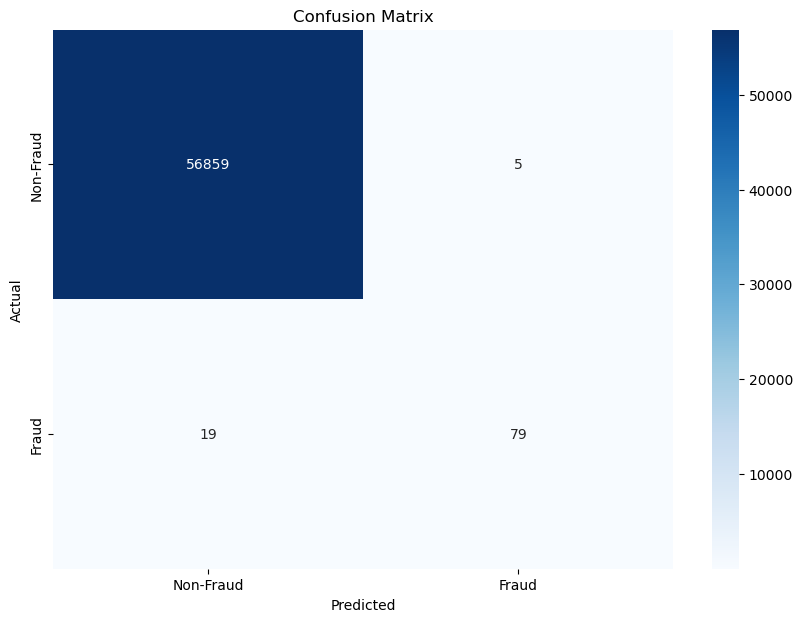


Time taken to run code cell: 691.8569982051849 seconds


In [14]:
# Comment out as takes longer than 10 minutes to run cell

# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialise the RandomForest model
rf_model = RandomForestClassifier(random_state=42)

# Initialise Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Lists to store results
cv_scores = []
conf_matrices = []

# Perform cross-validation
start_time = time.time()

for train_index, val_index in cv.split(X_train, y_train):
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model on the training fold
    rf_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_val_pred = rf_model.predict(X_val_fold)
    
    # Evaluate F1 score for this fold
    f1_fold = f1_score(y_val_fold, y_val_pred)
    cv_scores.append(f1_fold)
    
    # Print classification report and confusion matrix for this fold
    print(f"Fold F1 Score: {f1_fold}")
    print("Classification Report:")
    print(classification_report(y_val_fold, y_val_pred, target_names=['Non-Fraud', 'Fraud']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val_fold, y_val_pred))
    print("="*50)
    
    # Store confusion matrix for later analysis if needed
    conf_matrices.append(confusion_matrix(y_val_fold, y_val_pred))
    
# Train the final model on the entire training set
rf_model.fit(X_train, y_train)



# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model using the F1 score on the test set
f1_test = f1_score(y_test, y_pred)

# Print cross-validation scores
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", sum(cv_scores) / len(cv_scores))

# Print the F1 score and classification report on the test set
print("\nTest Set Performance:")
print("F1 Score:", f1_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Print the confusion matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Measure the end time
end_time = time.time()
time_taken = end_time - start_time
print(f"\nTime taken to run code cell: {time_taken} seconds")


#### RandomForest - Undersampled

Fold F1 Score: 0.08460236886632826
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.96      0.98     45491
       Fraud       0.04      0.96      0.08        78

    accuracy                           0.96     45569
   macro avg       0.52      0.96      0.53     45569
weighted avg       1.00      0.96      0.98     45569

Confusion Matrix:
[[43871  1620]
 [    3    75]]
Fold F1 Score: 0.10318664643399088
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.97      0.99     45490
       Fraud       0.05      0.86      0.10        79

    accuracy                           0.97     45569
   macro avg       0.53      0.92      0.55     45569
weighted avg       1.00      0.97      0.99     45569

Confusion Matrix:
[[44319  1171]
 [   11    68]]
Fold F1 Score: 0.11948051948051948
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       

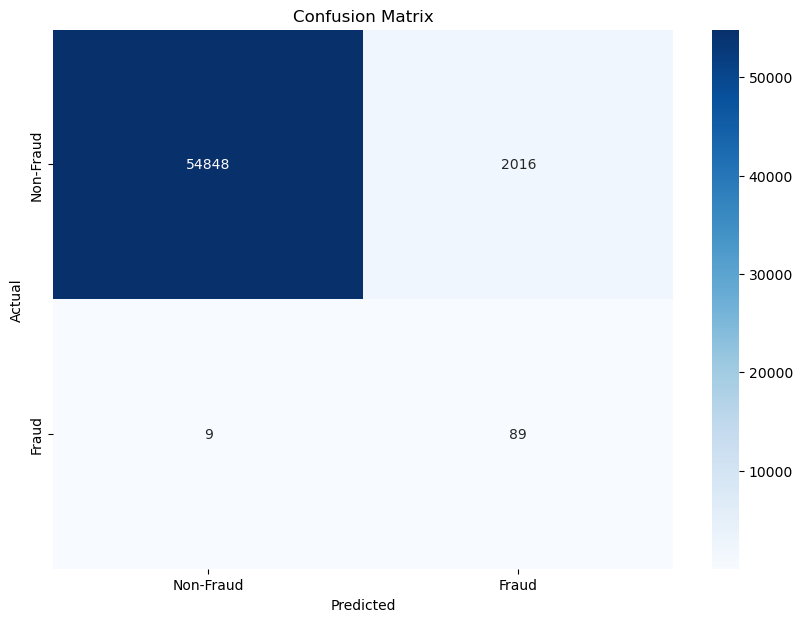


Time taken to run code cell: 2.881349802017212 seconds


In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialise the RandomForest model
rf_model = RandomForestClassifier(random_state=42)

# Initialise Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Lists to store results
cv_scores = []
conf_matrices = []

# Perform cross-validation
start_time = time.time()

for train_index, val_index in cv.split(X_train, y_train):
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Separate the majority and minority classes in the training fold
    fraud_train_fold = X_train_fold[y_train_fold == 1]
    non_fraud_train_fold = X_train_fold[y_train_fold == 0]

    # Undersample the majority class
    non_fraud_train_fold_undersampled = non_fraud_train_fold.sample(n=len(fraud_train_fold), random_state=42)

    # Combine the undersampled majority class with the minority class
    X_train_fold_undersampled = pd.concat([non_fraud_train_fold_undersampled, fraud_train_fold])
    y_train_fold_undersampled = y_train_fold.loc[X_train_fold_undersampled.index]

    # Train the model on the undersampled training fold
    rf_model.fit(X_train_fold_undersampled, y_train_fold_undersampled)

    # Predict on the validation fold
    y_val_pred = rf_model.predict(X_val_fold)

    # Evaluate F1 score for this fold
    f1_fold = f1_score(y_val_fold, y_val_pred)
    cv_scores.append(f1_fold)

    # Print classification report and confusion matrix for this fold
    print(f"Fold F1 Score: {f1_fold}")
    print("Classification Report:")
    print(classification_report(y_val_fold, y_val_pred, target_names=['Non-Fraud', 'Fraud']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val_fold, y_val_pred))
    print("=" * 50)

    # Store confusion matrix for later analysis if needed
    conf_matrices.append(confusion_matrix(y_val_fold, y_val_pred))

# Train the final model on the entire undersampled training set
fraud_train = X_train[y_train == 1]
non_fraud_train = X_train[y_train == 0]
non_fraud_train_undersampled = non_fraud_train.sample(n=len(fraud_train), random_state=42)
X_train_undersampled = pd.concat([non_fraud_train_undersampled, fraud_train])
y_train_undersampled = y_train.loc[X_train_undersampled.index]
rf_model.fit(X_train_undersampled, y_train_undersampled)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model using the F1 score on the test set
f1_test = f1_score(y_test, y_pred)

# Print cross-validation scores
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

# Print the F1 score and classification report on the test set
print("\nTest Set Performance:")
print("F1 Score:", f1_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Print the confusion matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Measure the end time
end_time = time.time()
time_taken = end_time - start_time
print(f"\nTime taken to run code cell: {time_taken} seconds")


#### Random Forest with SMOTE

In [ ]:
# Measure the time taken to make predictions
start_time = time.time()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# train the RandomForest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_oversampled, y_train_oversampled)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model using the F1 score
f1 = f1_score(y_test, y_pred)

# Print the F1 score and classification report
print("F1 Score:", f1)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Print the confusion matrix for additional insight
cnf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cnf_matrix)

end_time = time.time()
time_taken = end_time - start_time
print(f"Time take to run code cell: {time_taken}")


F1 Score: 0.8333333333333334
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.85      0.82      0.83        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56850    14]
 [   18    80]]
Time take to run code cell: 260.37607502937317


#### XGBoost

In [20]:
# Measure the time taken to make predictions
start_time = time.time()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Lists to store results
cv_scores = []
conf_matrices = []




for train_index, val_index in cv.split(X_train, y_train):
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    xgb_model.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_val_pred = xgb_model.predict(X_val_fold)

    # Evaluate F1 score for this fold
    f1_fold = f1_score(y_val_fold, y_val_pred)
    cv_scores.append(f1_fold)

    # Print classification report and confusion matrix for this fold
    print(f"Fold F1 Score: {f1_fold}")
    print("Classification Report:")
    print(classification_report(y_val_fold, y_val_pred, target_names=['Non-Fraud', 'Fraud']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val_fold, y_val_pred))
    print("=" * 50)

    # Store confusion matrix for later analysis if needed
    conf_matrices.append(confusion_matrix(y_val_fold, y_val_pred))

# Train the final model on the entire training set
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model using the F1 score on the test set
f1_test = f1_score(y_test, y_pred)

# Print cross-validation scores
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

# Print the F1 score and classification report on the test set
print("\nTest Set Performance:")
print("F1 Score:", f1_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Print the confusion matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Measure the end time
end_time = time.time()
time_taken = end_time - start_time
print(f"\nTime taken to run code cell: {time_taken} seconds")


Fold F1 Score: 0.8591549295774649
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     45491
       Fraud       0.95      0.78      0.86        78

    accuracy                           1.00     45569
   macro avg       0.98      0.89      0.93     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix:
[[45488     3]
 [   17    61]]
Fold F1 Score: 0.8633093525179857
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     45490
       Fraud       1.00      0.76      0.86        79

    accuracy                           1.00     45569
   macro avg       1.00      0.88      0.93     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix:
[[45490     0]
 [   19    60]]
Fold F1 Score: 0.8413793103448275
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.0

#### XGBoost with hyperparameter tuning

In [172]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Measure the time taken to make predictions
start_time = time.time()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define the parameter distributions for Random Search
param_dist = {
    'max_depth': [3, 6, 9, 12, 15],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'n_estimators': [100, 200, 300, 400, 500],
    'min_child_weight': [1, 3, 5, 7, 10],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
}

# Initialize RandomizedSearchCV with the XGBoost model and parameter distributions
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, 
                                   n_iter=50, scoring='f1', cv=5, verbose=1, random_state=42)



# Perform random search on the training data
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", random_search.best_params_)
print()

# Get the best model from random search
best_model = random_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model using the F1 score
f1 = f1_score(y_test, y_pred)

# Print the F1 score and classification report
print("F1 Score:", f1)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Print the confusion matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Measure the end time
end_time = time.time()
time_taken = end_time - start_time
print(f"\nTime taken to run code cell: {time_taken:.2f} seconds")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 7, 'max_depth': 15, 'learning_rate': 0.1711111111111111, 'gamma': 0.3, 'colsample_bytree': 0.9}

F1 Score: 0.8602150537634408
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.91      0.82      0.86        98

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56856     8]
 [   18    80]]

Time taken to run code cell: 463.06 seconds


#### XGBoost and SMOTE

In [21]:
# Measure the time taken to make predictions
start_time = time.time()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store cross-validation results
cv_scores = []
conf_matrices = []

for train_index, val_index in cv.split(X_train, y_train):
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Apply SMOTE to the training fold
    smote = SMOTE(random_state=42)
    X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    # Train the model on the resampled training fold
    xgb_model.fit(X_train_fold_resampled, y_train_fold_resampled)

    # Predict on the validation fold
    y_val_pred = xgb_model.predict(X_val_fold)

    # Evaluate F1 score for this fold
    f1_fold = f1_score(y_val_fold, y_val_pred)
    cv_scores.append(f1_fold)

    # Print classification report and confusion matrix for this fold
    print(f"Fold F1 Score: {f1_fold}")
    print("Classification Report:")
    print(classification_report(y_val_fold, y_val_pred, target_names=['Non-Fraud', 'Fraud']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val_fold, y_val_pred))
    print("=" * 50)

    # Store confusion matrix for later analysis if needed
    conf_matrices.append(confusion_matrix(y_val_fold, y_val_pred))


    

# Train the final model on the entire resampled training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model using the F1 score on the test set
f1_test = f1_score(y_test, y_pred)

# Print cross-validation scores
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

# Print the F1 score and classification report on the test set
print("\nTest Set Performance:")
print("F1 Score:", f1_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Print the confusion matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Measure the end time
end_time = time.time()
time_taken = end_time - start_time
print(f"\nTime taken to run code cell: {time_taken:.2f} seconds")


Fold F1 Score: 0.7664670658682635
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     45491
       Fraud       0.72      0.82      0.77        78

    accuracy                           1.00     45569
   macro avg       0.86      0.91      0.88     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix:
[[45466    25]
 [   14    64]]
Fold F1 Score: 0.782608695652174
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     45490
       Fraud       0.77      0.80      0.78        79

    accuracy                           1.00     45569
   macro avg       0.88      0.90      0.89     45569
weighted avg       1.00      1.00      1.00     45569

Confusion Matrix:
[[45471    19]
 [   16    63]]
Fold F1 Score: 0.7590361445783133
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00

#### XGBoost with undersampling

In [22]:
# Measure the time taken to make predictions
start_time = time.time()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)




cv_scores = []
conf_matrices = []


for train_index, val_index in cv.split(X_train, y_train):
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Undersample the majority class in the training fold
    fraud_train_fold = X_train_fold[y_train_fold == 1]
    non_fraud_train_fold = X_train_fold[y_train_fold == 0]
    non_fraud_train_fold_undersampled = non_fraud_train_fold.sample(n=len(fraud_train_fold), random_state=42)
    X_train_fold_undersampled = pd.concat([non_fraud_train_fold_undersampled, fraud_train_fold])
    y_train_fold_undersampled = y_train_fold.loc[X_train_fold_undersampled.index]

    # Train the model on the undersampled training fold
    xgb_model.fit(X_train_fold_undersampled, y_train_fold_undersampled)

    # Predict on the validation fold
    y_val_pred = xgb_model.predict(X_val_fold)

    # Evaluate F1 score for this fold
    f1_fold = f1_score(y_val_fold, y_val_pred)
    cv_scores.append(f1_fold)

    # Print classification report and confusion matrix for this fold
    print(f"Fold F1 Score: {f1_fold}")
    print("Classification Report:")
    print(classification_report(y_val_fold, y_val_pred, target_names=['Non-Fraud', 'Fraud']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val_fold, y_val_pred))
    print("=" * 50)

    # Store confusion matrix for later analysis if needed
    conf_matrices.append(confusion_matrix(y_val_fold, y_val_pred))

# Train the final model on the entire undersampled training set
fraud_train = X_train[y_train == 1]
non_fraud_train = X_train[y_train == 0]
non_fraud_train_undersampled = non_fraud_train.sample(n=len(fraud_train), random_state=42)
X_train_undersampled = pd.concat([non_fraud_train_undersampled, fraud_train])
y_train_undersampled = y_train.loc[X_train_undersampled.index]
xgb_model.fit(X_train_undersampled, y_train_undersampled)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model using the F1 score on the test set
f1_test = f1_score(y_test, y_pred)

# Print cross-validation scores
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

# Print the F1 score and classification report on the test set
print("\nTest Set Performance:")
print("F1 Score:", f1_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Print the confusion matrix for additional insight
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Measure the end time
end_time = time.time()
time_taken = end_time - start_time
print(f"\nTime taken to run code cell: {time_taken:.2f} seconds")


Fold F1 Score: 0.06969280146721686
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.96      0.98     45491
       Fraud       0.04      0.97      0.07        78

    accuracy                           0.96     45569
   macro avg       0.52      0.96      0.52     45569
weighted avg       1.00      0.96      0.98     45569

Confusion Matrix:
[[43464  2027]
 [    2    76]]
Fold F1 Score: 0.08571428571428572
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.97      0.98     45490
       Fraud       0.04      0.91      0.09        79

    accuracy                           0.97     45569
   macro avg       0.52      0.94      0.53     45569
weighted avg       1.00      0.97      0.98     45569

Confusion Matrix:
[[43961  1529]
 [    7    72]]
Fold F1 Score: 0.07557502738225631
Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       